In [ ]:
import sys
sys.path.append('../')

import torch
import pandas as pd
from scipy.sparse.linalg import spsolve
from tqdm import tqdm

from HeatMultibcDs import C2ValDS, C4ValDs
from UniformICD import UniformFVM
from Problems.BlockSourceProblem import BlockSourceProblem
from utils import layout2csv, ChipLayout
from MyPlot import *
from BaseTester import BaseTester
from scipy.sparse import load_npz


In [ ]:
class HeatTester(BaseTester):
	def __init__(self,  **kwargs):
		super().__init__(**kwargs)
		self.boundary_gap = 0.001
		self.chip_gap = 0.001
		self.mesh()
		# self.gen_linsys()

		self.h = 0.1 / self.GridSize
	
	def l2(self, pre, ans):
		return np.sqrt(((pre - ans)**2 * self.h**2).sum())
	
	def relative_l2(self, pre, ans):
		return np.sqrt(((pre - ans)**2).sum()) / np.sqrt((ans**2).sum())
			
	def init_test_ds(self, DataN):			
		match self.kwargs['net_kwargs']['in_channels']:
			case 2:
				ds1 = C2ValDS(self.GridSize, DataN, self.dtype, self.device, [1]*DataN) 
				ds2 = C2ValDS(self.GridSize, DataN, self.dtype, self.device, [2]*DataN) 
				ds3 = C2ValDS(self.GridSize, DataN, self.dtype, self.device, [3]*DataN) 
			case 4:
				ds1 = C4ValDs(self.GridSize, DataN, self.dtype, self.device, [1]*DataN) 
				ds2 = C4ValDs(self.GridSize, DataN, self.dtype, self.device, [2]*DataN) 
				ds3 = C4ValDs(self.GridSize, DataN, self.dtype, self.device, [3]*DataN) 
			
		self.all_ds = [ds1, ds2, ds3]

	def test(self, exp_name, DataN, best_or_last):
		self.load_kwargs(exp_name)
		self.init_test_ds(DataN)
		self.load_ckpt(best_or_last, exp_name)

		df = {
			# 'id': [],
			'l2_bd1': [],
			'l2_bd2': [],
			'l2_bd3': []

		}

		with torch.no_grad():
			for i, ds in enumerate(self.all_ds):
				for data, ans in ds:
					# pre = self.net(data[None, ...])**2 + 298 
					pre = self.net(data[None, ...])

					# l2 = self.relative_l2(pre.cpu().numpy().squeeze(), ans.cpu().numpy().squeeze())
					l2 = self.l2(pre.cpu().numpy().squeeze(), ans.cpu().numpy().squeeze())
					df[f'l2_bd{i+1}'].append(l2)
					
				# if  max(errors) < 0.015:
				# 	for j in range(3):
				# 		self.save_img(f"{self.img_save_path}/{exp_name}/TestCase-{i}-{j}", pre[j], ans[j], boundary[j], layout[j])

		df = pd.DataFrame(df)
		p = Path(f"{self.img_save_path}/{exp_name}")
		if not p.is_dir():
			p.mkdir(parents=True)
		df.to_csv(f"{self.img_save_path}/{exp_name}/l2-{best_or_last}.csv", index=False)
		
	def save_img(self, path, pre, ans, boundary, Force):
		p = Path(path)
		if not p.is_dir():
			p.mkdir(parents=True)

		pre = pre.cpu().numpy().reshape(self.GridSize, self.GridSize)
		ans = ans.reshape(self.GridSize, self.GridSize)
		boundary = boundary.cpu().numpy().reshape(self.GridSize, self.GridSize)
		Force = Force.cpu().numpy().reshape(self.GridSize, self.GridSize)

		save_surf(path, pre, self.xx, self.yy, 'surf_pre', cmap=cm.coolwarm)
		save_surf(path, ans, self.xx, self.yy, 'surf_ref', cmap=cm.coolwarm)
		save_ctf(path, pre, ans, self.xx, self.yy, cmap=cm.coolwarm)
		save_contour(path, pre, ans, self.xx, self.yy, levels=None)
		save_img_force(path, Force, 'force', cmap=cm.coolwarm)
		save_img_force(path, boundary, 'boundary', cmap=cm.coolwarm)

In [ ]:
heat_tester = HeatTester(
    GridSize=128,
    area=((0, 0), (0.1, 0.1)),
    ckpt_save_path=f'model_save',
    hyper_parameters_save_path = f'hyper_parameters', 
    img_save_path = f'./images', 
    device='cuda',
    dtype=torch.double,
    )

exp_name = 'C2_double'
best_or_last='last'

DataN = 2000
heat_tester.test(exp_name, DataN, best_or_last)

0.017586006740056056


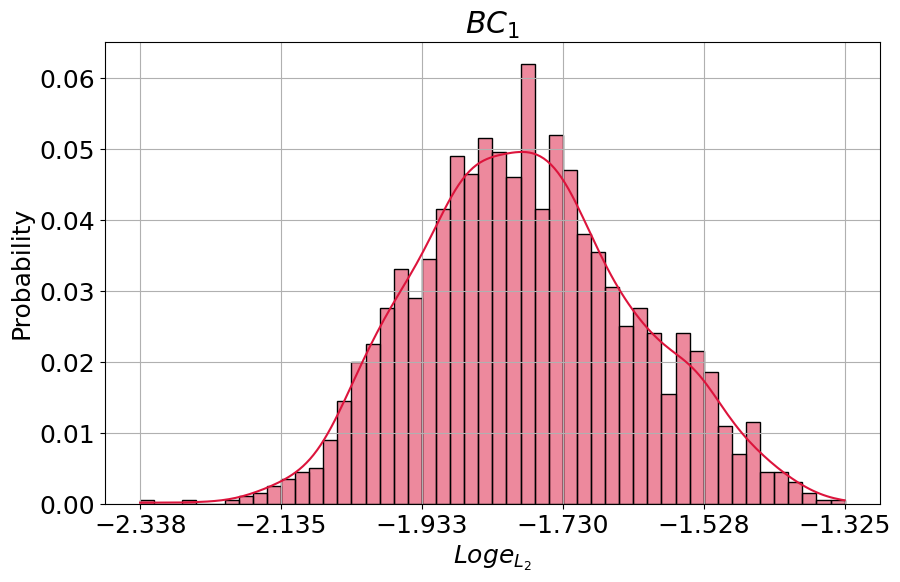

0.038871184569964495


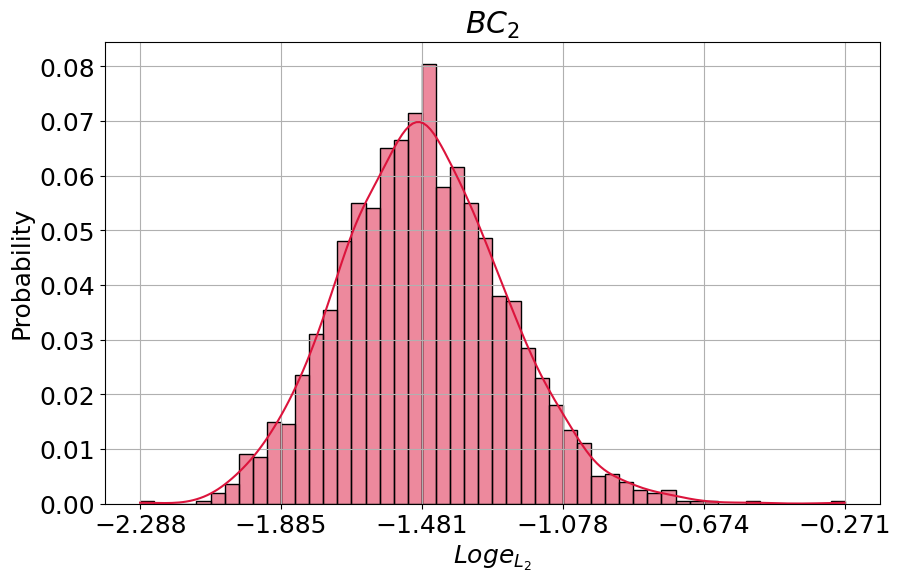

0.11256589978763908


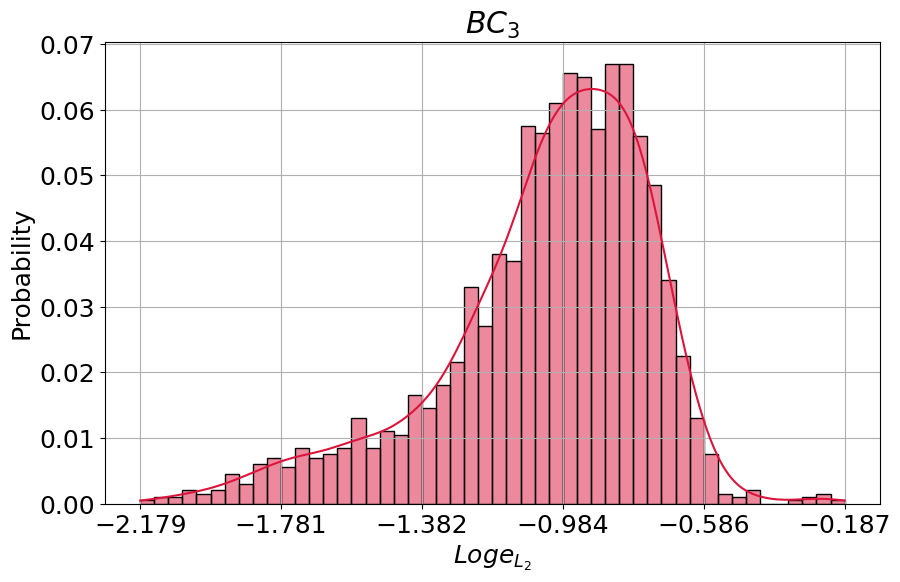

0.05634103036588654


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# df = pd.read_csv('./images/128/C4_298_relu/l2-last.csv')
df = pd.read_csv('./images/128/C2_double/l2-last.csv')

vals = []
for i in [1, 2, 3]:
	fig = plt.figure(figsize=(10, 6))  # Set the figure size
	plt.rcParams['font.size'] = 18  # Default font size
		# plt.rcParams['axes.titlesize'] 		= 18  # Font size for axes titles
		# plt.rcParams['axes.labelsize'] 		= 16  # Font size for axes labels
		# plt.rcParams['xtick.labelsize'] 	= 12  # Font size for x-tick labels
		# plt.rcParams['ytick.labelsize'] 	= 12  # Font size for y-tick labels
		# plt.rcParams['legend.fontsize'] 	= 20  # Font size for legend
		# plt.rcParams['figure.titlesize'] 	= 20  # Font size for figure title
	data = np.log10(df[f'l2_bd{i}'])
	ax = sns.histplot(
		# df[f'l2_bd{i}'].rolling(window=5).mean(),b
		data,
		bins=50,  # Number of bins
		kde=True,  # Add KDE (Kernel Density Estimate)
		stat='probability',  # Normalize the histogram
		color='crimson',  # Color of the bars
		edgecolor='black'  # Color of the edges,
		
	)
	print(df[f'l2_bd{i}'].mean())
	vals.append(df[f'l2_bd{i}'].values)
	# Customization
	plt.title(f'$BC_{i}$')  # Title of the plot
	plt.xticks(np.linspace(data.min(), data.max(), 6))
	plt.xlabel('$Log e_{L_2}$')  # X-axis label
	plt.ylabel('Probability')  # Y-axis label
	plt.grid(True)  # Show grid lines
	plt.show()
	fig.savefig(f'./test_bd{i}.png')
	plt.close()
vals = np.vstack(vals)
print(vals.mean())

(6000, 1)
0.05634103036588654


<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_55992/358733165.py:25: SyntaxWarning: invalid escape sequence '\m'
  plt.title('$\mathcal{P}_{BC}$')  # Title of the plot


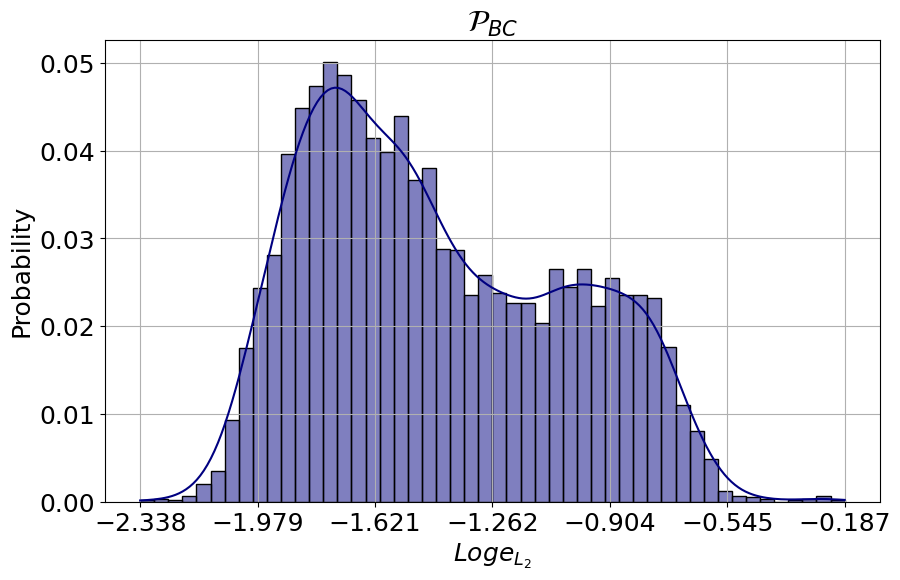

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df = pd.read_csv('./images/128/C2_double/l2-last.csv')

all_data = pd.concat([df[f'l2_bd{i}'] for i in [1, 2, 3]]).reset_index(drop=True)
df1 = pd.DataFrame({'all': all_data})
print(df1.shape)

fig = plt.figure(figsize=(10, 6))  # Set the figure size
plt.rcParams['font.size'] = 18  # Default font size
data = np.log10(df1['all'])
sns.histplot(
	data,
	bins=50,  # Number of bins
	kde=True,  # Add KDE (Kernel Density Estimate)
	stat='probability',  # Normalize the histogram
	color='navy',  # Color of the bars
	edgecolor='black'  # Color of the edges
)
print(df1['all'].mean())

# Customization
plt.title('$\mathcal{P}_{BC}$')  # Title of the plot
plt.xticks(np.linspace(data.min(), data.max(), 7))
plt.xlabel('$Log e_{L_2}$')  # X-axis label
plt.ylabel('Probability')  # Y-axis label
plt.grid(True)  # Show grid lines
plt.show()
fig.savefig(f'./all_test.png')
plt.close()